# RV and Transit for HD209458 b
## Using RV and transit data to estimate mass and radius of planet and calculating uncertainty

### Import necessary packages and data tables for RV and transit

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import astropy.io.ascii
plt.ion()
%matplotlib inline

In [4]:
#tr_data = astropy.io.ascii.read("UID_0108859_PLC_003.tbl.txt", data_start=131, delimiter='|')
#data for HD209458 b transit data 
#data from Exoarchive Optical(Most) Rowe et al 2006
#data starts at line 130

In [5]:
rv_data = astropy.io.ascii.read("UID_0108859_RVC_002.tbl.txt")
#laughlin et al 2006, used 10m Keck 1 HIRES
#rv data for HD209458 b

### Plot RV data and best fit model

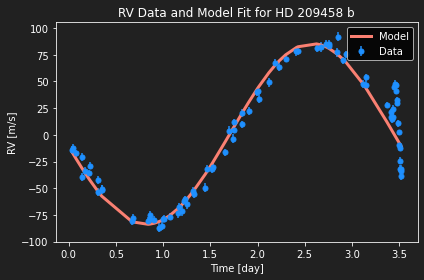

In [24]:
#plot the RV data and use radvel to fit the model using various parameters
t = rv_data["HJD"].data
if False:
    import JW_lib
    orbital_solution = [3.52474859, 2452765.790, 0.0100, 0, 84.7]
    rv = JW_lib.RadialVelocity(orbital_solution)
    #The parameters are period, time at periastron, eccentricity, argument of periastron, RV semi-amplitude
    #here, i used values from naef et al 2004, Rosenthal et al 2021 to start and then adjusted as i saw fit to fit the model
    #https://exoplanetarchive.ipac.caltech.edu/overview/HD%20209458

    # Calculate model RVs
    rvs = rv.rv_drive(t)
else:
    import radvel
    orbital_solution = [3.52474859, 2452765.790, 0.0100, 0 / 360.0 * 2 * np.pi, 84.7]
    rvs = radvel.kepler.rv_drive(t, orbital_solution, use_c_kepler_solver=False)

per = 3.5247485

%matplotlib inline
# Fold data and plot model against data
ind = np.argsort(t % per)
plt.style.use('dark_background')
plt.figure(facecolor='#212121') 
ax = plt.axes()
ax.set_facecolor("#212121")
plt.errorbar(rv_data["HJD"] % per, rv_data["Radial_Velocity"], rv_data["Radial_Velocity_Uncertainty"], 
             color="dodgerblue", ms=5, marker="o", ls="none", label="Data")
plt.plot((t % per)[ind], rvs[ind], "r-", label="Model", color='salmon', lw=3)
plt.legend()
plt.title("RV Data and Model Fit for HD 209458 b")
plt.xlabel("Time [day]")
plt.ylabel("RV [m/s]")
plt.savefig('1.png', dpi=300)
plt.tight_layout()

### Fitting RV data

In [14]:
import scipy.signal as signal
x = rv_data["HJD"]
y = rv_data["Radial_Velocity"]
e = rv_data["Radial_Velocity_Uncertainty"]

## Finding Periodicity

In [15]:
nout = 1e5
f = np.linspace(0.01, 10.0, int(nout)) # frequency (1/day) at which power is calculated. 
#pgram = signal.lombscargle(x, y, f, normalize=True)
pgram = signal.lombscargle(x, y, f)

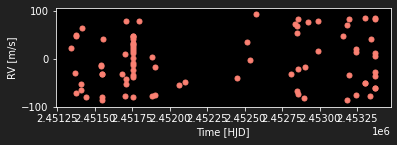

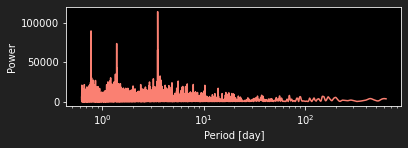

In [26]:
plt.style.use('dark_background')
plt.figure(facecolor='#212121') 
ax = plt.axes()
ax.set_facecolor("#212121")
plt.subplot(2, 1, 1)
plt.errorbar(x, y , e, ms=5, marker="o", ls="none", color="salmon")
plt.xlabel("Time [HJD]")
plt.ylabel("RV [m/s]")
plt.savefig('2.png', dpi=300)

plt.style.use('dark_background')
plt.figure(facecolor='#212121') 
ax = plt.axes()
ax.set_facecolor("#212121")
plt.subplot(2, 1, 2)
plt.plot(2 * np.pi / f, pgram, color="salmon")
plt.xscale("log")
plt.xlabel("Period [day]")
plt.ylabel("Power")
plt.savefig('3.png', dpi=300)

In [45]:
print("The period with the highest power is: ", 2 * np.pi / f[np.where(pgram == np.max(pgram))][0], " day")

The period with the highest power is:  3.5246452355396656  day


## Calculate Mass of HD 209458 b from RV data

In [75]:
#we need mass_star, rv_semi_amplitude, eccentricity, semi_maj_axis, 
#and assume circular orbit to find minmass_planet in terms of mass_star?
#mass_star = 1.06917519587500 solar masses
#rv_semi_amplitude = max RV-min RV/2 = 91.9-(-86.9)/2 = 89.4 m/s
#semi_maj_axis from rosenthal et al 2021 = 0.04634+0.00069-0.00070 AU = 6932365328 meters
#period = 3.52474859 days (not needed)
#eccentricity = 0.01

semimaj_axis_AU = 0.04634 #semi major axis in AU
K_ms = 89.4 #rv semi amplitude in m/s
m_star_sol= 1.06917519587500 #mass of star in solar masses
ecc=0.01 #eccentricity

#semiamplitude eqn
#K~28.4ms^-1(a/AU)^(-1/2)(msini/Mj)(Mstar/Msun)^(-1/2)(1-e^2)^(-1/2)
#solve for msini
#msini = K*(1/28.4ms^-1)(AU/a)^(-1/2)(Msun/Mstar)^(-1/2)(1/(1-e^2))^(-1/2) 
#^minimum mass in jupiter masses

min_mass = K_ms*(1/28.4)*(1/semimaj_axis_AU)**(-1/2)*(1/m_star_sol)**(-1/2)*(1/(1-(ecc)**2))**(-1/2)

print('The minimum mass of HD 209458 b is', min_mass, 'Jupiter masses')


The minimum mass of HD 209458 b is 0.700648045897449 Jupiter masses


### MCMC and Error

In [47]:
# def calcModel(params, t_stamp=None):
#     per, t0, ecc, omega, rv_amp = params["per"], params["t0"], params["ecc"], params["omega"], params["K"]
#     rv = JW_lib.RadialVelocity([per, t0, ecc, omega, rv_amp])
#     return(rv.rv_drive(t_stamp))

def calcModel(params, t_stamp=None):
    per, t0, ecc, omega, rv_amp = params["per"], params["t0"], params["ecc"], params["omega"], params["K"]
    return(radvel.kepler.rv_drive(t_stamp, [per, t0, ecc, omega, rv_amp], use_c_kepler_solver=False))

In [58]:
#define prior
def b_range(x, b):
    if x > b:
        return -np.inf
    else:
        return 0.

def a_b_range(x, a, b):
    if x < a:
        return -np.inf
    elif x > b:
        return -np.inf
    else:
        return 0.

def log_gaussian_prior(x, x0, std):
    return((-(x - x0)**2 / (2 * (std)**2)) / 2.3)




# define data and params that are fixed and variable
#planet_name = "HD 209458 b"
planet_name = "HD 209458 b"

if planet_name == "Teegarden b":
    log_priors = {}
    log_priors['per']           = lambda x: a_b_range(x, 4.8, 5.0)
    log_priors['t0']           = lambda x: a_b_range(x, 2458090.603207, 2458092.603207)
    log_priors['ecc']           = lambda x: a_b_range(x, 0., 0.95)
    log_priors['omega']       = lambda x: a_b_range(x, 0., 2*np.pi)
    log_priors['K']           = lambda x: a_b_range(x, 1., 5.)
    t_stamp      = rv_tg["col1"]
    data         = rv_tg["col2"]
    data_errors  = rv_tg["col3"]

    params = [4.910122, 2458091.603207, 0.222619, 82.339257 / 360 * 2 * np.pi,2.156248]
    params_keys = ["per", "t0", "ecc", "omega", "K"]
    params_fixed = []
    params_fixed_keys = []
elif planet_name == "HD 209458 b":
    log_priors = {}
    log_priors['per']           = lambda x: a_b_range(x, 3, 4)
    log_priors['t0']           = lambda x: a_b_range(x, 2452765.700, 2452765.900)
    log_priors['ecc']           = lambda x: a_b_range(x, 0., 0.02)
    log_priors['omega']       = lambda x: a_b_range(x, 0., 1.)
    log_priors['K']           = lambda x: a_b_range(x, 80., 90.)
    t_stamp      = rv_data["HJD"]
    data         = rv_data["Radial_Velocity"]
    data_errors  = rv_data["Radial_Velocity_Uncertainty"]

    params = [3.52474859, 2452765.790, 0.0100, 0 / 360.0 * 2 * np.pi, 84.7]
    params_keys = ["per", "t0", "ecc", "omega", "K"]
    params_fixed = []
    params_fixed_keys = []
else:
    print(""" Give me either "HD 209458 b" or "Teegarden b" """)

In [56]:
# likelihood function
def calc_log_prob(params, data, data_errors, params_keys=params_keys, params_fixed=params_fixed, \
                  params_fixed_keys=params_fixed_keys, t_stamp=t_stamp, plot_flag=False):
    # Make dictionary 
    params_dic = {}
    for i, key in enumerate(params_keys):
        params_dic[key]       = params[i]

    for i, key in enumerate(params_fixed_keys):
        params_dic[key]       = params_fixed[i]

    # Prior calculation of all input parameters
    log_prior = 0.

    for key in params_keys:
        if not(type(params_dic[key]) is list):
            log_prior += log_priors[key](params_dic[key])
        else:
            for val in params_dic[key]:
                log_prior += log_priors[key](val)

    # Return -inf if parameters fall outside prior distribution
    if (log_prior == -np.inf):
        return -np.inf
    
    # Calculate the log-likelihood
    log_likelihood = 0.

    # Calculate the forward model, this
    # returns the wavelengths in um and flux in W/m2

    rv_model = calcModel(params_dic, t_stamp=t_stamp)

    if plot_flag:
        plt.plot(t_stamp, rv_model, "k^-", alpha=0.5, label="model")
        plt.plot(t_stamp, data, "rx-", alpha=0.5, label="data")
        plt.xlabel("Time [HJD]")
        plt.ylabel("RV [m/s]")
        plt.legend()
        plt.show()

    # Just to make sure that a long chain does not die
    # unexpectedly:
    # Return -inf if forward model returns NaN values
    if np.sum(np.isnan(rv_model)) > 0:
        print("NaN spectrum encountered")
        return -np.inf

    # Calculate log-likelihood
    log_likelihood += -np.sum(((rv_model - data)/ \
                       data_errors)**2.)/2.

    if np.isnan(log_prior + log_likelihood):
        return -np.inf
    else:
        return log_prior + log_likelihood




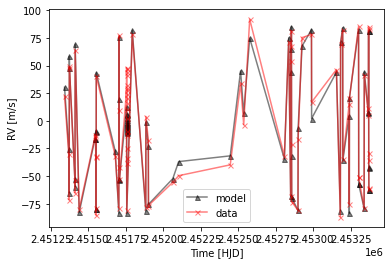

-938.7739427664508


In [59]:
#test likelihood fxn
print(calc_log_prob(params, data, data_errors, plot_flag=True))

In [60]:
#start mcmc
import emcee

In [61]:
per = params[0]; e_per = 0.01
t0 = params[1]; e_t0 = 0.05
ecc = params[2]; e_ecc = 0.01
omega = params[3]; e_omega = 0.1
K = params[4]; e_K = 0.1


p_0 = params
e_p = [e_per, e_t0, e_ecc, e_omega, e_K]


ndim, nwalkers, nruns = len(p_0), 200, 1000
pos = [p_0 + e_p*np.random.randn(ndim) for i in range(nwalkers)]

import time as timer
start = timer.time()

from multiprocessing import Pool

# if pool works then use True, this option will use multi thread to increase computaional speed. Otherwise use False.
if False: 
    with Pool() as pool:

        # Initialize the sampler
        sampler = emcee.EnsembleSampler(nwalkers, ndim, calc_log_prob,
                                       args=(data, data_errors), pool=pool, threads=5)
        sampler.run_mcmc(pos, 3000)


        #End timer
        end = timer.time()
        serial_time = end - start
        print("MCMC took {0:.1f} seconds".format(serial_time))
else:
        # Initialize the sampler
        sampler = emcee.EnsembleSampler(nwalkers, ndim, calc_log_prob,
                                       args=(data, data_errors))
        sampler.run_mcmc(pos, 3000)


        #End timer
        end = timer.time()
        serial_time = end - start
        print("MCMC took {0:.1f} seconds".format(serial_time))    





MCMC took 408.1 seconds


In [62]:
#check mcmc result
samples = sampler.chain[:, 1000:, :].reshape((-1, ndim))[0:-1:10, :]


print("flat chain shape: {0}".format(samples.shape))



flat chain shape: (40000, 5)


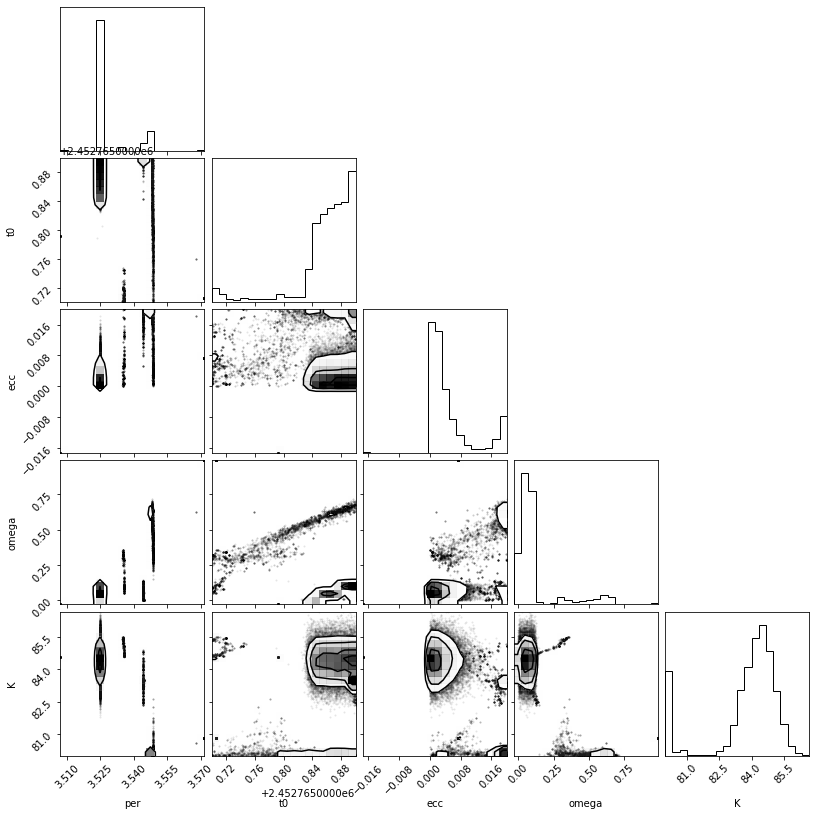

In [63]:
import corner
fig = corner.corner(samples, labels=params_keys, plot_contours=True)

## Plot models with data

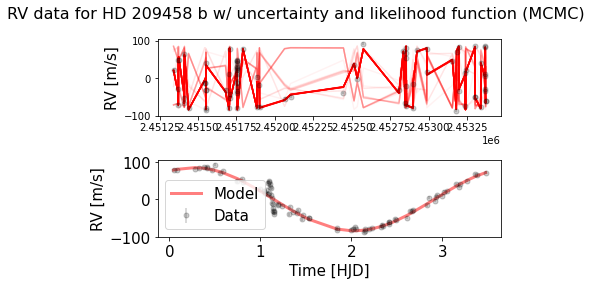

In [71]:
fig, ax = plt.subplots(2,1)
fig.suptitle('RV data for HD 209458 b w/ uncertainty and likelihood function (MCMC)', fontsize=16)


inds = np.random.randint(len(samples[:,0]), size=100)
for ind in inds:
    # Make dictionary 
    params_dic = {}
    for i, key in enumerate(params_keys):
        params_dic[key]       = samples[ind,:][i]        
    for i, key in enumerate(params_fixed_keys):
        params_dic[key]       = params_fixed[i]
    #print(params_dic["logg"])
    rv_model = calcModel(params_dic, t_stamp=t_stamp)
    ax[0].plot(t_stamp, rv_model, 'r', alpha=0.05,label='_nolegend_')
    
    
ax[0].errorbar(t_stamp, data, data_errors, ms=5, marker="o", alpha=0.2, ls="none", color="black", label="Data")
ax[0].plot(t_stamp, rv_model, "r", alpha=0.5, label="Model")


# Getting median values
values = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
                             zip(*np.percentile(samples, [16, 50, 84],
                                                axis=0)))
params = np.array(list(values))[:,0]
params_fixed = []
params_dic = {}
for i, key in enumerate(params_keys):
    params_dic[key]       = params[i]
for i, key in enumerate(params_fixed_keys):
    params_dic[key]       = params_fixed[i]

rv_model = calcModel(params_dic, t_stamp=t_stamp)
per = params_dic["per"]
ind1 = np.argsort(t_stamp % per)
ax[1].errorbar(t_stamp % per, data, data_errors, ms=5, marker="o", alpha=0.2, ls="none", color="black", label="Data")
ax[1].plot((t_stamp % per)[ind1], rv_model[ind1], "r", alpha=0.5,label='Model', lw=3)

ax[1].set_xlabel("Time [HJD]", fontsize=15)
ax[0].set_ylabel("RV [m/s]", fontsize=15)
ax[1].set_ylabel("RV [m/s]", fontsize=15)

plt.gca().tick_params(labelsize=15)
ax[1].legend(fontsize=15)
plt.tight_layout()

# plt.savefig("model_data.png")

### Calculate Transit Best fit model

In [39]:
#import pylightcurve
import pylightcurve as plc

In [40]:
#try to define planet to test plc
planet = plc.get_planet('hd209458b')

In [41]:

#current issue: attribute error:  module 'pylightcurve' has no attribute 'clablimb' etc

#manual entry
#use NEA: Rosenthal et al 2021 and laughlin et al table to get parameters
#i cant find the fp over fs...

planet, stellar_logg, stellar_temperature, stellar_metallicity, rp_over_rs, \
fp_over_fs, period, sma_over_rs, eccentricity, inclination, periastron, mid_time = \
"HD 209458 b", 4.30739612512000, 6026.3549454750, -0.005500315269770001, 0.12086, 2.4367028655531474e-07, \
3.52474859, 8.81, 0.01, 86.71, 0, 2453233.4063

#uncomment this next bit for an automatic search for these properties from pylightcurve
#planet, stellar_logg, stellar_temperature, stellar_metallicity, rp_over_rs, fp_over_fs, period, sma_over_rs, eccentricity, inclination, periastron, mid_time) = plc.find_oec_parameters('hd209458b')

time_array = tr_data["JD"].data
# time_array = tr_data["col1"].data

# Calculate Limb-darkening parameters
#limb_darkening_coefficients = plc.clablimb('claret', stellar_logg, stellar_temperature, 
                                               #stellar_metallicity, 'V')

# Calculate transiting light curve
flux_array = plc.transit_integrated('claret', limb_darkening_coefficients, rp_over_rs, period, sma_over_rs, eccentricity, inclination, periastron, mid_time, time_array, 120, 120, precision=6)

TypeError: only size-1 arrays can be converted to Python scalars

### Plot transit data and best fit model

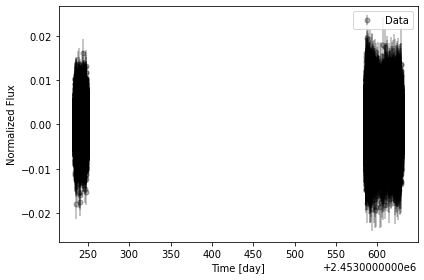

In [42]:
plt.errorbar(tr_data["JD"], tr_data["Relative_Magnitude"], tr_data["Relative_Magnitude_Uncertainty"], ms=5, \
             marker="o", ls="none", label="Data", color="black", alpha=0.3)

# flx = 2.512**(-tr_data["Relative_Magnitude"])
# flx = flx / np.median(flx)
# plt.plot(tr_data["col1"], flx , ms=5, \
#              marker="o", ls="none", label="Data", color="black", alpha=0.3)

#plt.plot(time_array, flux_array, 'r-', lw=3, label="Model")
plt.ylim(plt.ylim()[0], plt.ylim()[1])
plt.xlabel('Time [day]')
plt.ylabel('Normalized Flux')
plt.legend()
plt.tight_layout()